In [1]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.30
    Uninstalling SQLAlchemy-2.0.30:
      Successfully uninstalled SQLAlchemy-2.0.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.
ipython-sql 0.5.0 requires sqlalc

In [2]:
import os
import numpy as np
from sklearn.ensemble import IsolationForest
from obspy import read

In [3]:
import matplotlib.pyplot as plt

In [4]:
dic = '/kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data/'
os.chdir(dic)
print("Current working directory:", os.getcwd())
files = [f for f in os.listdir('.') if os.path.isfile(f) and f.endswith('.mseed')]
files

Current working directory: /kaggle/input/space-apps-2024-seismic-detection/space_apps_2024_seismic_detection/data/mars/test/data


['XB.ELYSE.02.BHV.2022-05-04HR23_evid0001.mseed',
 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0034.mseed',
 'XB.ELYSE.02.BHV.2019-05-23HR02_evid0041.mseed',
 'XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed',
 'XB.ELYSE.02.BHV.2022-04-09HR22_evid0002.mseed',
 'XB.ELYSE.02.BHV.2021-12-24HR22_evid0007.mseed',
 'XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed',
 'XB.ELYSE.02.BHV.2021-05-02HR01_evid0017.mseed',
 'XB.ELYSE.02.BHV.2021-10-11HR23_evid0011.mseed']

Detected seismic events:
Event 1: Start = 1907.23s, End = 2072.88s


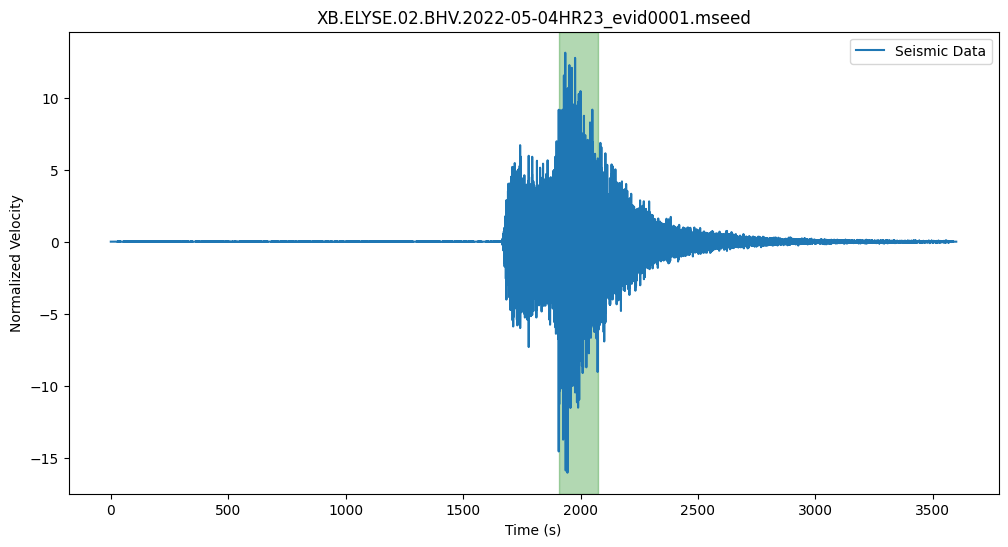

Detected seismic events:
Event 1: Start = 756.36s, End = 759.91s


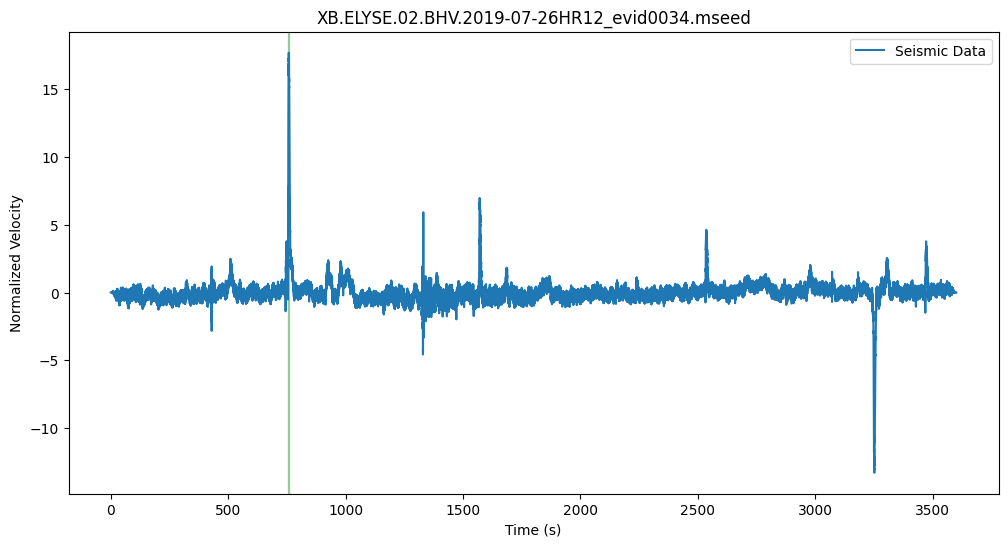

Detected seismic events:
Event 1: Start = 2289.23s, End = 2292.98s


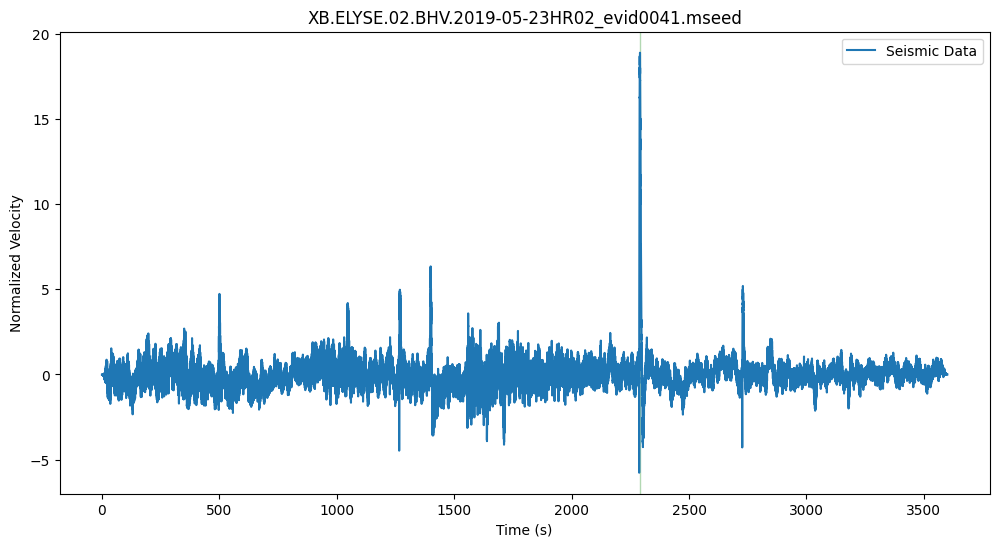

Detected seismic events:
Event 1: Start = 756.36s, End = 759.91s


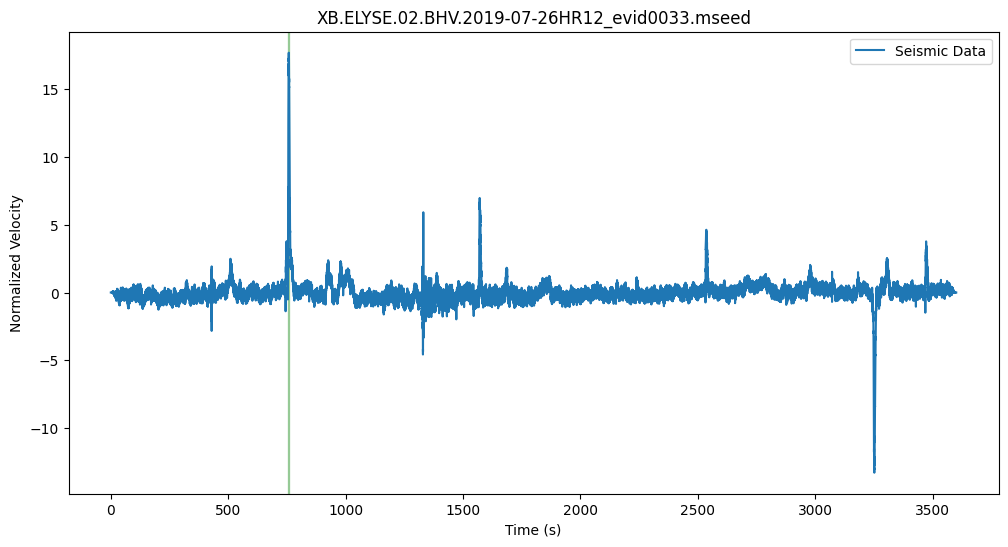

Detected seismic events:
Event 1: Start = 403.06s, End = 709.11s


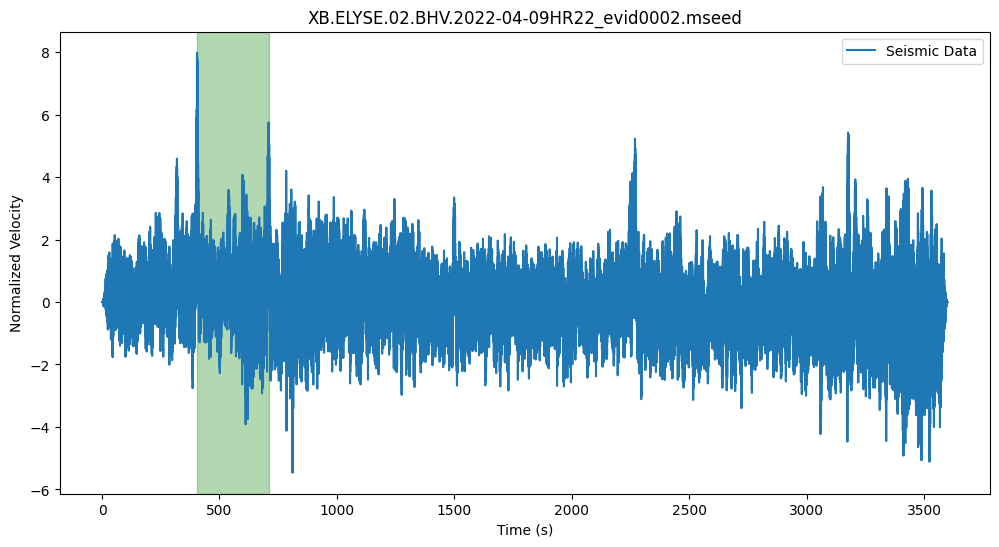

Detected seismic events:
Event 1: Start = 2730.19s, End = 3241.75s


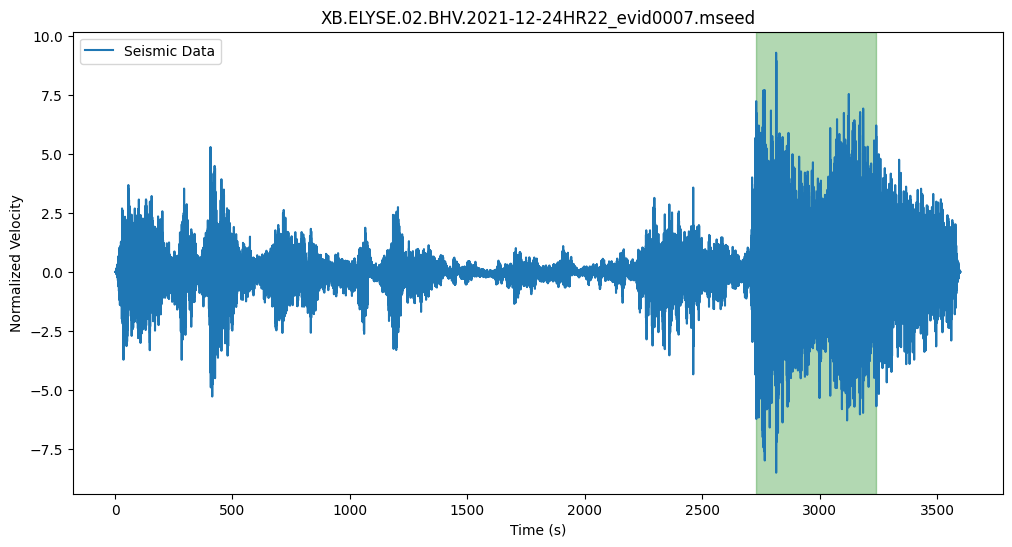

Detected seismic events:
Event 1: Start = 115.25s, End = 118.75s


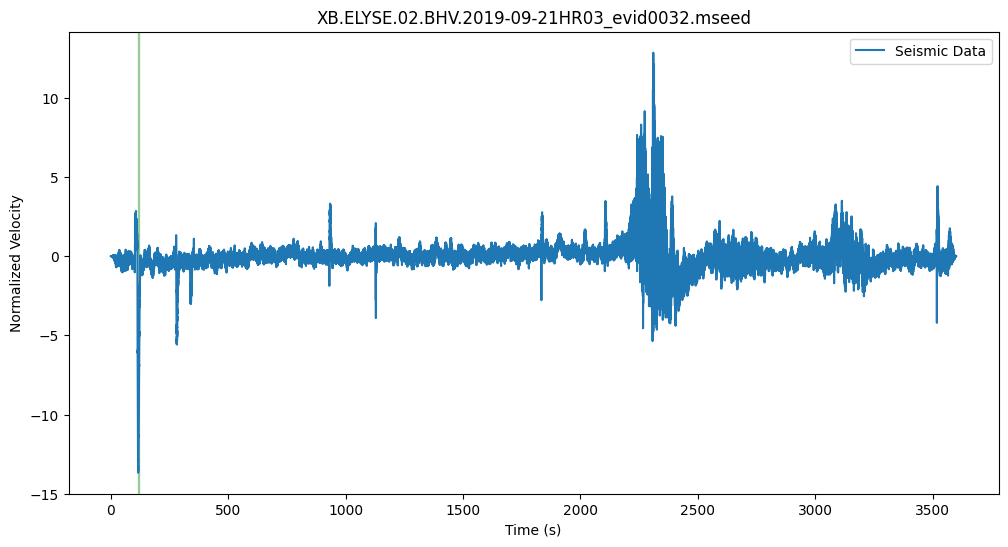

Detected seismic events:
Event 1: Start = 608.56s, End = 609.81s
Event 2: Start = 1656.12s, End = 1658.92s


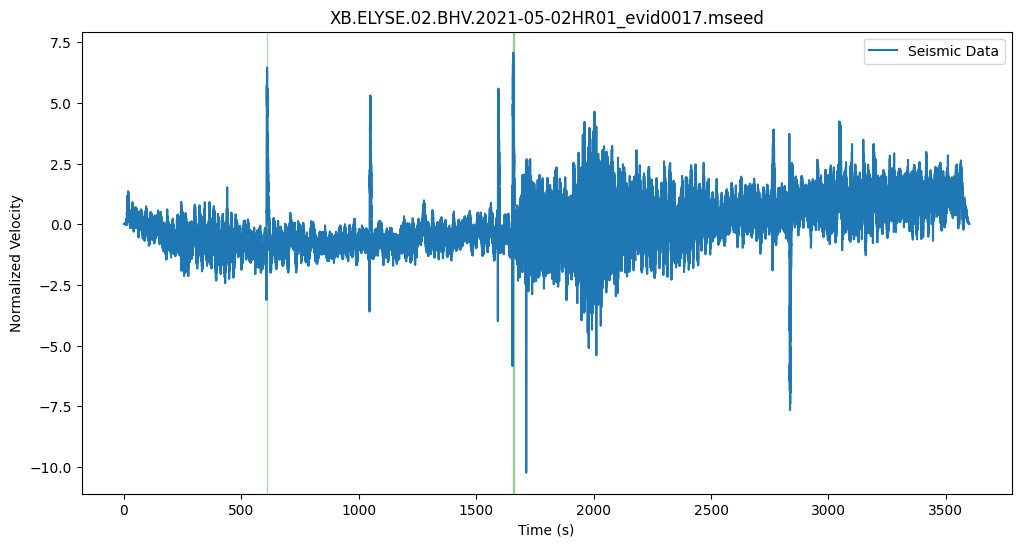

Detected seismic events:
Event 1: Start = 289.25s, End = 917.66s
Event 2: Start = 1729.02s, End = 1822.73s
Event 3: Start = 2784.99s, End = 3371.00s


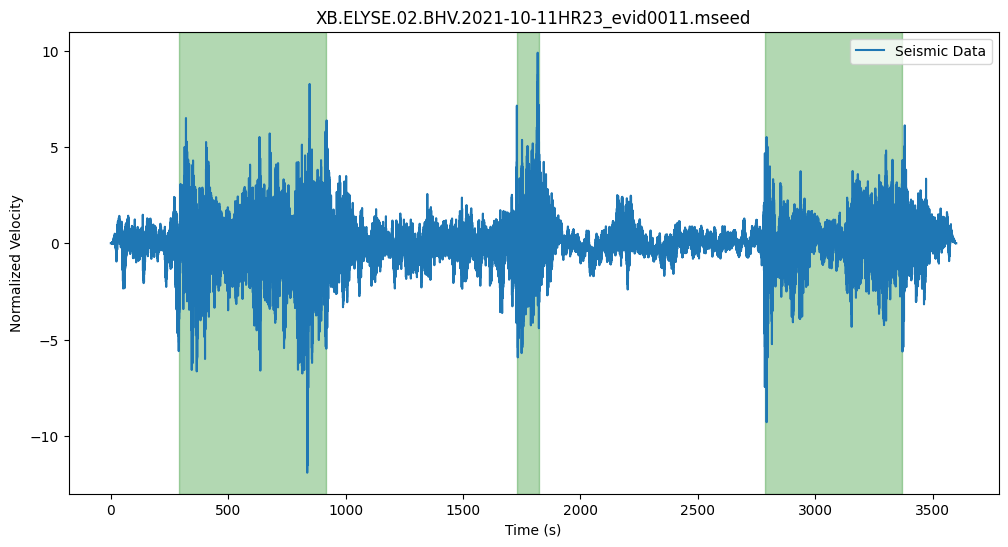

In [5]:
for file in files:
    st = read(dic+file)
    tr = st[0]
    tr_data = tr.data
    tr_times = np.linspace(0, len(tr_data) / tr.stats.sampling_rate, num=len(tr_data))
    tr_data_norm = (tr_data - np.mean(tr_data)) / np.std(tr_data)
    data_points = tr_data_norm.reshape(-1, 1)

    iso_forest = IsolationForest(contamination=0.001, random_state=42)
    iso_forest.fit(data_points)
    anomalies = iso_forest.predict(data_points)
    anomalies_indices = np.where(anomalies == -1)[0]

    event_times = tr_times[anomalies_indices]

    events = []
    max_gap = 600
    current_event_start = event_times[0]
    current_event_end = event_times[0]

    event_times = tr_times[anomalies_indices]

    clustered_points = [event_times[0]]  
    proximity_threshold = 600
    min_points_required = 5
    for i in range(1, len(event_times)):
        nearby_points = np.sum((event_times >= event_times[i] - proximity_threshold) & (event_times <= event_times[i] + proximity_threshold))
        if nearby_points >= min_points_required and event_times[i] - clustered_points[-1] >= 600:
            clustered_points.append(event_times[i])

    for i in range(1, len(event_times)):
        time_diff = event_times[i] - event_times[i - 1]
        if time_diff <= max_gap:
            current_event_end = event_times[i]
        else:
            events.append((current_event_start, current_event_end))
            current_event_start = event_times[i]
            current_event_end = event_times[i]

    events.append((current_event_start, current_event_end))

    print("Detected seismic events:")
    for idx, (start_time, end_time) in enumerate(events):
        print(f"Event {idx + 1}: Start = {start_time:.2f}s, End = {end_time:.2f}s")

    plt.figure(figsize=(12, 6))
    plt.plot(tr_times, tr_data_norm, label='Seismic Data')

    for start_time, end_time in events:
        plt.axvspan(start_time, end_time, color='green', alpha=0.3)

    plt.title(file)
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Velocity')
    plt.legend()
    plt.show()
